In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text
from scipy import stats
from collections import defaultdict

In [ ]:
### Honeyguides AND cuckoo finches

In [54]:
### Read male / female file 
# db = 'indInd'
db = 'anoImb'
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'PopGen_{}/dict.male_female.tsv'.format(db)

sex_dict = defaultdict(list)
with open(file_name, 'r') as inf:
    for line in inf.readlines():
        sample = line.rstrip().split('\t')[0]
        sex = line.rstrip().split('\t')[1]
        sex_dict[sex].append(sample)

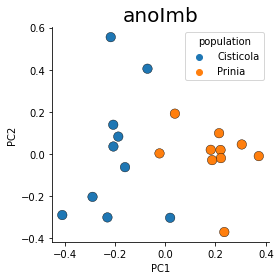

In [18]:
## General PCA on all chromosomes
db = 'anoImb'
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/{}_PCA/'.format(db)
file_name = '{}_full.eigenvec'.format(db)
file_data = glob(dir_path + file_name)[0]
pca_df = pd.read_csv(file_data, sep='\t')


fig, axes = plt.subplots(figsize=(4, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='population',
                        s=90, edgecolor='k', linewidth=0.4)
        
axes.set_title('{}'.format(db), fontsize=20)
fig.tight_layout()  
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

pdf_name = 'PCA_samples.all_chroms.{}.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

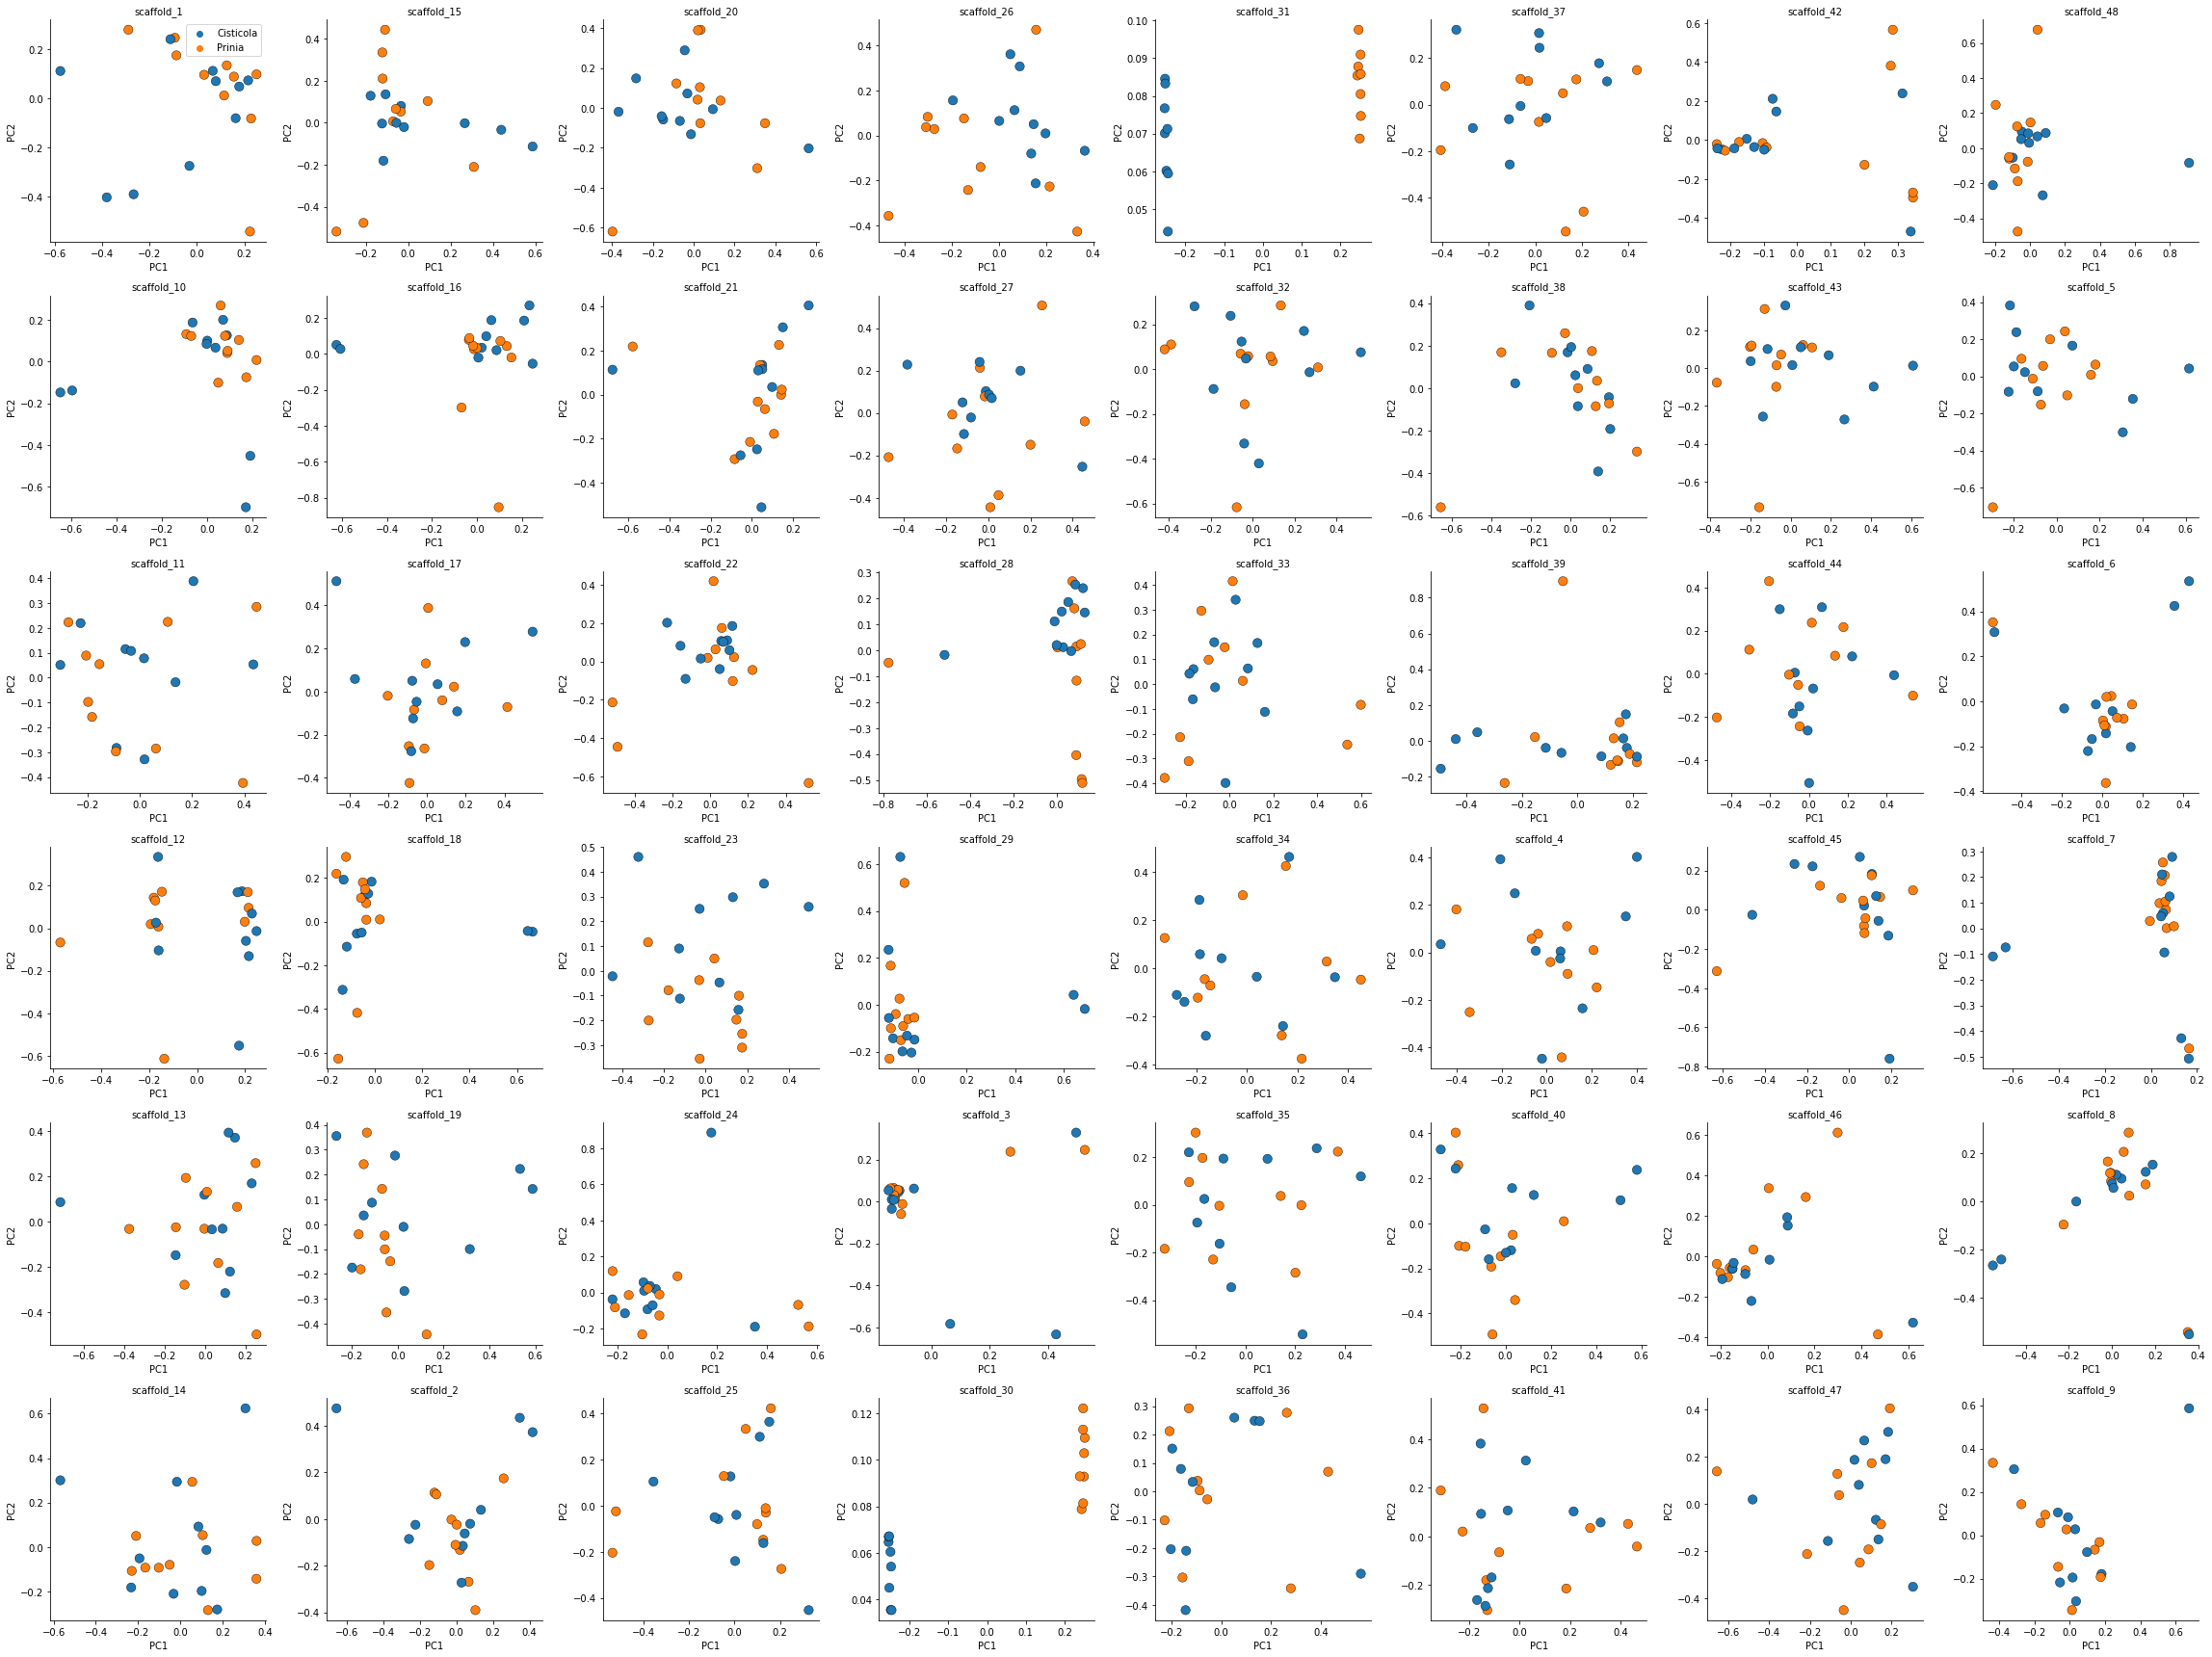

In [55]:
## Do tree and ground honeyguides separate (PCA) if we look chr by chr?

db = 'anoImb'
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
# vector_path = 'split_by_chr_PCA_indInd/'
vector_path = '{}_PCA/split_by_chr_PCA/'.format(db)

# sex_chroms = ['chrZ', 'chrW', 'chrZ.CM051124', 'chrW.CM051123']
sex_chroms = ['scaffold_30', 'scaffold_31']

vector_files = [dir_path + vector_path + f for f in listdir(dir_path + vector_path) if f.endswith('labeled')]
vector_files = sorted(vector_files)

fig, axes = plt.subplots(6, 8, figsize=(4*8, 4*6))

for j in range(8):
    for i in range(6):        
        k = 6 * j + i
        try:
            f = vector_files[k]
        except IndexError:
            break
            
        pca_df = pd.read_csv(f, sep='\t')
        axi = axes[i][j]
        title = f.replace(dir_path + vector_path, '').replace('.passed.{}.pca.eigenvec.labeled'.format(db), '')
        
        if title in sex_chroms:
            filt_pca_df = pca_df[pca_df['IID'].isin(sex_dict['female'])]
        else:
            filt_pca_df = pca_df
        
        sns.scatterplot(ax=axi, data=filt_pca_df, x='PC1', y='PC2', hue='population',
                        s=90, edgecolor='k', linewidth=0.4)
        
        axi.set_title('{}'.format(title), fontsize=10)
        fig.tight_layout()  
        sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
        
        if (i == 0) and (j == 0):
            axi.legend().set_title('')
        else:
            axi.legend([], [], frameon=False)            

pdf_name = 'PCA_samples.by_chromosome.{}.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

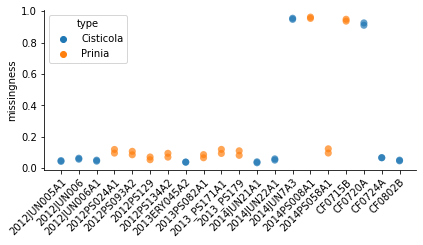

In [57]:
### Which samples are male / female?

# db = 'indInd'
db = 'anoImb'
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/'
file_name = 'PopGen_{}/missing_data.sex_chr.tsv'.format(db)

file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

fig, axes = plt.subplots(figsize=(6, 3.5))
# sns.scatterplot(data=df, y='missing', x='sample', hue='type', linewidth=0, alpha=0.7, s=50)
sns.scatterplot(data=df, y='missing', x='sample', hue='chr', linewidth=0, alpha=0.7, s=50)

# df = df[df['chr'].isin(['outlier_Z_400kb'])]
# sns.scatterplot(data=df, y='missing', x='sample', hue='type', linewidth=0, alpha=0.7, s=50)

plt.setp(axes.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
axes.set(xlabel='', ylabel='missingness')
fig.tight_layout()  
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)

# pdf_name = 'missingness_chrW.{}.prinia_VS_cisticola.pdf'.format(db)
pdf_name = 'missingness_chrW.{}.to_male_female.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

In [8]:
def make_position(dfi, col_chr, col_start):
    ## sorts by chromosome number and adds absolute postion column
    
    dfi = dfi.dropna()
    exclude = ['chrZ', 'chrW', 'chrNA', 'chrMT']
    dfi['COUNT'] = dfi[col_chr].str.replace('chr', '')
    dfi['COUNT'] = dfi[col_chr].str.replace('scaffold_', '')
    
    dfi_num = dfi[ ~dfi[col_chr].isin(exclude)]
    dfi_Z = dfi[dfi[col_chr] == 'chrZ']
    dfi_W = dfi[dfi[col_chr] == 'chrW']
    
    dfi_num['COUNT'] = pd.to_numeric(dfi_num['COUNT'])
    dfi_num = dfi_num.sort_values(by=['COUNT', col_start])
    
    dfi_merged = pd.concat([dfi_num, dfi_Z, dfi_W], ignore_index=True)
    dfi_merged['POSITION'] = [x / 1000 for x in range(dfi_merged.shape[0])]
    return dfi_merged

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


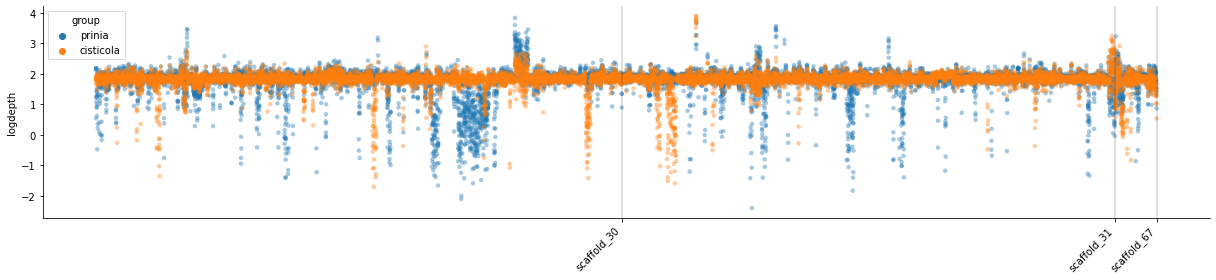

In [56]:
## How much is missing in sex chromosomes per window in Prinia VS Cisticola cuckoo finches?
db = 'anoImb'
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/PopGen_{}/'.format(db)
# file_name = 'window_100.chrW.prinia_cisticola.missingness.tsv'
file_name = 'prinia_vs_cisticola.females.all_depth.1kb.tsv'


# ## How much is missing in sex chromosomes per window in tree VS ground honeyguides?
# db = 'indInd'
# dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/PopGen_{}/'.format(db)
# file_name = 'window_100.chrZ_chrW.tree_ground.missingness.tsv'

file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')
# df = df[df['chr'] == 'chrZ']

fig, axes = plt.subplots(figsize=(17, 4*1))
# ax1, ax2 = axes[0], axes[1]
p = sns.color_palette("tab10")

df_pop1 = df[df['group'] == 'prinia']
df_pop2 = df[df['group'] == 'cisticola']
df_pop1_sorted = make_position(df_pop1, 'chr', 'location')
df_pop2_sorted = make_position(df_pop2, 'chr', 'location')
df_merged = pd.concat((df_pop1_sorted, df_pop2_sorted), ignore_index=True)

# for missingness
# y_value = 'missing'

# for read depth
df_merged['logdepth'] = np.log10(df_merged['depth'])
y_value = 'logdepth'
# axes.set_ylim(0, 100)

sns.scatterplot(data=df_merged, x='POSITION', y=y_value, 
                s=20, linewidth=0, alpha=0.4, hue='group')

ends = list(df_merged.groupby('scaffold')['POSITION'].max())
ends_lables = df_merged[df_merged['POSITION'].isin(ends)]['scaffold']
for l in ends:
    axes.axvline(l, color='k', linewidth=0.25)
axes.set_xticks(ends)
axes.set_xticklabels(list(ends_lables) , rotation=45, ha='right')
axes.set_xlabel('')

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'missingness.chrW.tree_VS_ground.pdf'.format(db)
# pdf_name = 'missingness.{}.chrW.prinia_VS_cisticola.pdf'.format(db)
pdf_name = 'depth.{}.chrW.prinia_VS_cisticola.pdf'.format(db)

# fig.savefig(pdf_name, bbox_inches='tight')

In [26]:
## Check regions unique to Cisticola
# df_merged[df_merged['missing'] > 0.7]
low_depth_prinia = df_merged[(df_merged['logdepth'] < -0.5) & (df_merged['group'] == 'prinia')]
low_depth_prinia.to_csv('low_depth_in_prinia.chrW.tsv', sep='\t', index=False)

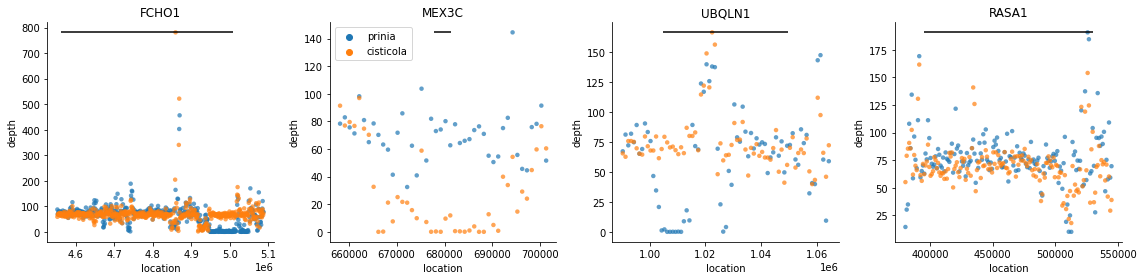

In [83]:
## Check depth 4 genes Mike didn't recover in one or another lineage
# FCHO2_W	scaffold_30 4562382 5007353
# MEX3C_W	scaffold_31 677721 681390
# UBQLN1_W	scaffold_31 1004685 1049750
# RASA1_W	scaffold_67 395145 530188

miss_genes = {'FCHO1': ('scaffold_30', 4562382, 5007353),
              'MEX3C': ('scaffold_31', 677721, 681390),
              'UBQLN1': ('scaffold_31', 1004685, 1049750),
              'RASA1': ('scaffold_67', 395145, 530188)}

fig, axes = plt.subplots(1, len(miss_genes), figsize=(4*len(miss_genes), 4))

i = 0
for g in miss_genes:
    axi = axes[i]
    scaffold = miss_genes[g][0]
    x1 = miss_genes[g][1]
    x2 = miss_genes[g][2]

    if g == 'FCHO1':
        cx1 = x1 - 10000 
        cx2 = x2 + 80000
    elif g == 'MEX3C':
        cx1 = x1 - 20000
        cx2 = x2 + 20000
    else:
        cx1 = x1 - 15000
        cx2 = x2 + 15000
        
    df_region = df_merged[(df_merged['scaffold'] == scaffold) &
                          (df_merged['location'] >= cx1) & 
                          (df_merged['location'] <= cx2)]
    axi.hlines(y=df_region['depth'].max(), xmin=x1, xmax=x2)
    y_value = 'depth'
    sns.scatterplot(ax=axi, data=df_region, x='location', y=y_value, 
                    s=20, linewidth=0, alpha=0.7, hue='group')
    axi.set_title(g)
    if i == 1:
        axi.legend().set_title('')
    else:
        axi.legend([], [], frameon=False)   
    i += 1

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()


pdf_name = 'depth.4_genes_Mikes_anno.chrW.prinia_VS_cisticola.pdf'.format(db)

# fig.savefig(pdf_name, bbox_inches='tight')

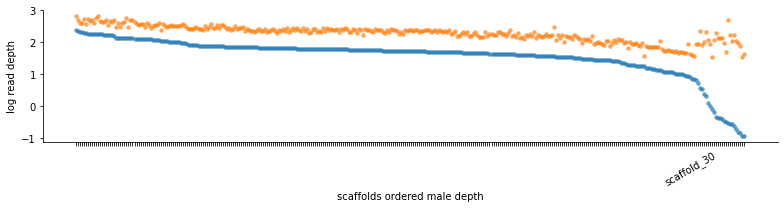

In [2]:
### Read depth by scaffold cuckoo finch
db = 'anoImb'
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/PopGen_{}/'.format(db)
file_name_m = 'males.all_depth.1kb.tsv'
file_name_f = 'females.all_depth.1kb.tsv'
file_data_m = glob(dir_path + file_name_m)[0]
file_data_f = glob(dir_path + file_name_f)[0]
df_m = pd.read_csv(file_data_m, sep='\t')[['chr', 'location', 'depth']]
df_f = pd.read_csv(file_data_f, sep='\t')[['chr', 'location', 'depth']]
df_m['logdepth'] = np.log10(df_m['depth'] + .1)
df_f['logdepth'] = np.log10(df_f['depth'] + .1)

fig, axes = plt.subplots(figsize=(11, 3*1))


# df_m_sorted = make_position(df_m, 'chr', 'location')
# df_f_sorted = make_position(df_f, 'chr', 'location')
# df_merged = pd.concat((df_f, df_m), ignore_index=True)
# df_merged['logdepth'] = np.log10(df_merged['depth'] + 1)
# df_group = df_merged.groupby(['chr', 'sex'])['logdepth'].mean().to_frame().reset_index()

df_m_g = df_m.groupby(['chr'])['logdepth'].mean().to_frame().reset_index()
df_f_g = df_f.groupby(['chr'])['logdepth'].mean().to_frame().reset_index()
df_merged = pd.merge(df_m_g, df_f_g, on='chr').sort_values(by='logdepth_x', ascending=False)
df_merged['ratio'] = df_merged['logdepth_x'] / df_merged['logdepth_y']

sns.scatterplot(data=df_merged, x='chr', y='logdepth_x', 
                s=20, linewidth=0, alpha=0.7)
sns.scatterplot(data=df_merged, x='chr', y='logdepth_y', 
                s=20, linewidth=0, alpha=0.7)

# sns.scatterplot(data=df_merged, x='chr', y='ratio')

chr_lables = [i if i in ['scaffold_30'] else '' for i in df_merged['chr']]
axes.set_xticklabels(chr_lables , rotation=30, ha='right')
axes.set_xlabel('scaffolds ordered male depth')
axes.set_ylabel('log read depth')

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

pdf_name = 'depth_by_scaffold.{}.male_female.pdf'.format(db)
# fig.savefig(pdf_name, bbox_inches='tight')

In [3]:
### Make list of chrW scaffolds
# chrW_scaffolds = df_merged[df_merged['ratio'] < 0.5]['chr']
# chrW_scaffolds